Plot the voltage signal $x(t)$ `trace1` from the microelectrode array and visually examine it. 
Spikes are very fast downward voltage excursions (sometimes reaching to ~ $ -100 \mu V$), followed 
by a small overshoot (zoom in to few spikes to see what they typically look like).

To get some sense of the signal, **plot a probability distribution function** (properly
normalized, so that $\int dx P (x) = 1$), of $x(t)$. **Estimate the error bars on the PDF**
by splitting the data multiple times into halves and compute the SD over PDF
estimates constructed from halves of the data. Is there any obvious feature for
negative voltages in the histogram where you could draw a threshold to recognize
the spikes easily? To identify the spikes, you can set a threshold. Scan a range of
thresholds, from $-70 \mu V$ and $-30 \mu V$ ; whenever the signal crosses the threshold
in a downward direction (please pay attention to this definition!), identify a
putative spike, and **plot the number of spikes as a function of the threshold**. By
examining the trace in detail, can you claim that any specific threshold is a good
choice for spike detection?

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import norm

In [4]:
# Import the data
trace1 = np.loadtxt(fname=('trace1.txt'))

The data vector consists of $2 \times 10^6$ voltage samples, sampled at $2 \times 10^4 Hz$, for a total of 100 seconds. 100 seconds / $2 \times 10^6$ samples = $\frac{1}{20,000}$ = $5 \times 10^{-5}$ seconds per sample.

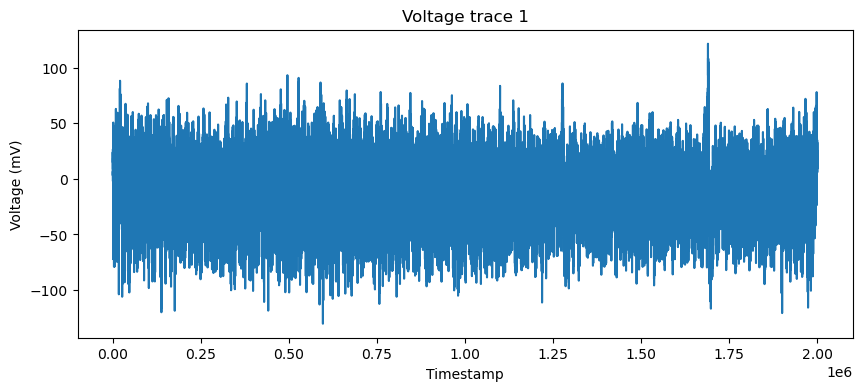

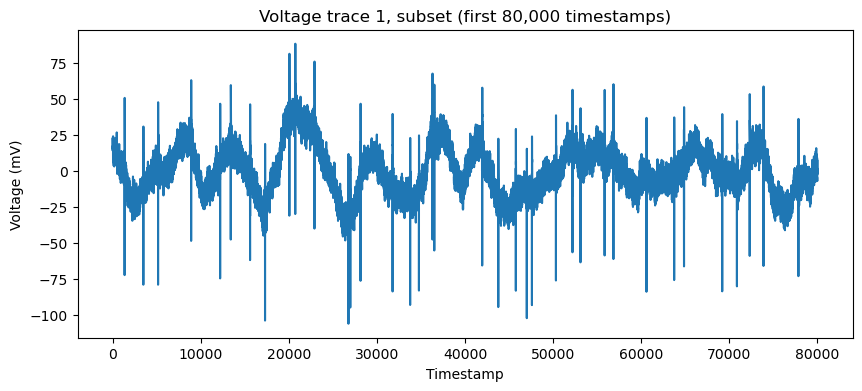

In [148]:
# Plot trace 1
plt.figure(figsize=(10,4))
plt.title('Voltage trace 1')
plt.xlabel('Timestamp')
plt.ylabel('Voltage (mV)')
plt.plot(trace1)
plt.show()

# Plot a subset
plt.figure(figsize=(10,4))
plt.title('Voltage trace 1, subset (first 80,000 timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Voltage (mV)')
plt.plot(trace1[0:80_000])
plt.show()

To get some sense of the signal, **plot a probability distribution function** (properly
normalized, so that $\int dx P (x) = 1$), of $x(t)$.

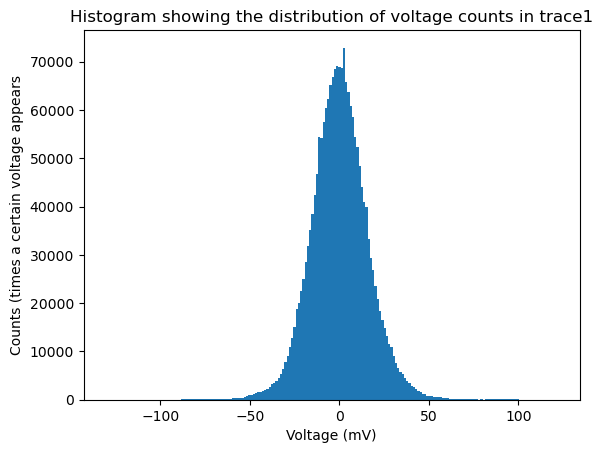

In [254]:
# First plot a histogram
numbins=200

plt.hist(trace1, bins=numbins)
plt.title('Histogram showing the distribution of voltage counts in trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('Counts (times a certain voltage appears')
plt.show()

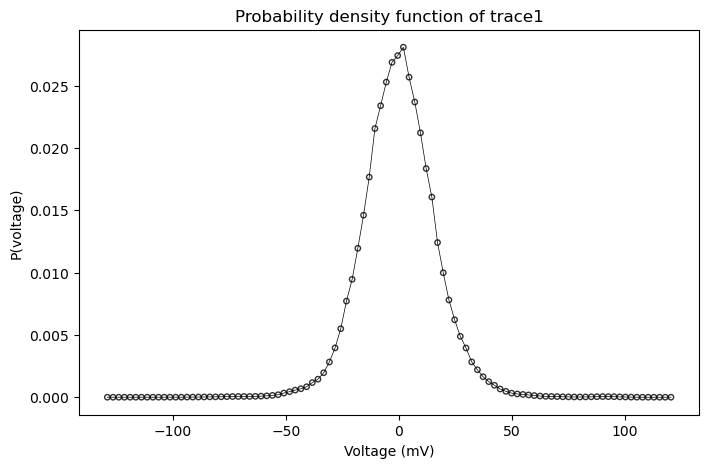

In [162]:
# Plot a normalized probability density function
numbins=100
counts, edges = np.histogram(trace1, bins=numbins, density=True)

# Get the center of the bin:
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin

# Plot the histogram:
plt.figure(figsize=(8,5))
plt.title('Probability density function of trace1')
plt.xlabel('Voltage (mV)')
plt.ylabel('P(voltage)')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')
plt.show()

# print(norm.support())

# # plt.plot(len(trace1), norm.pdf(trace1))
# plt.figure(figsize=(10,5))
# plt.plot(trace1, norm.pdf(trace1))
# plt.show()

The bin size was chosen to be 100 by trial and error. There are only 2022 unique values in the dataset (see below), so e.g. 1000 bins doesn't make sense.

In [15]:
len(np.unique(trace1))

2022

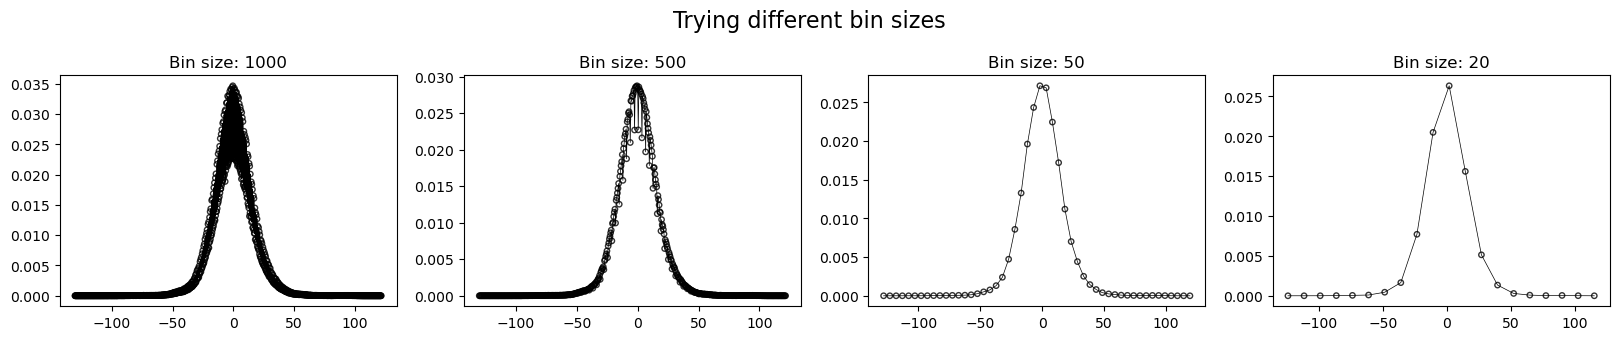

In [179]:
plt.figure(figsize=(20,3))
plt.suptitle('Trying different bin sizes', fontsize=16,y=1.1)

binsize=1000
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(141)
plt.title('Bin size: 1000')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=500
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(142)
plt.title('Bin size: 500')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=50
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(143)
plt.title('Bin size: 50')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

binsize=20
counts, edges = np.histogram(trace1, bins=binsize, density=True)
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin
plt.subplot(144)
plt.title('Bin size: 20')
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.plot(bin_centers, counts, linewidth=.5, color='k')

plt.show()

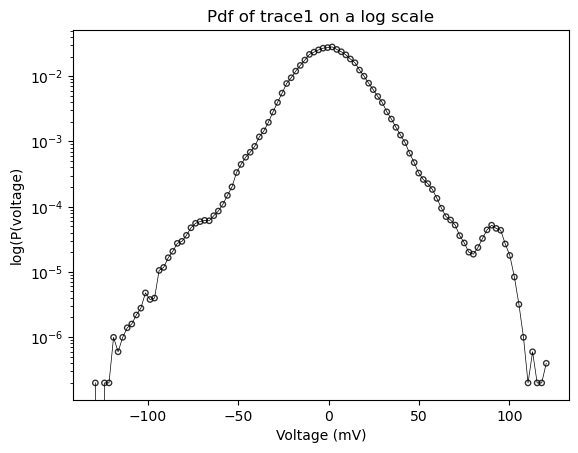

In [181]:
# Plot the histogram on a log scale
counts, edges = np.histogram(trace1, bins=numbins, density=True)

# Get the center of the bin:
bin_centers = (edges[1:]+edges[:-1])/ 2 # take the average of the consecutive edges of each bin

# Plot the histogram:
plt.scatter(bin_centers, counts, marker='o', s=15,facecolors='none', edgecolors='k', alpha=0.8)
plt.yscale('log')
plt.title('Pdf of trace1 on a log scale')
plt.xlabel('Voltage (mV)')
plt.ylabel('log(P(voltage)')
plt.plot(bin_centers, counts, linewidth=.5, color='k')

# # Superimpose a normal distribution
# mu = trace1.mean()
# sigma = trace1.std()
# normdist = stats.norm(mu, sigma)
# x = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
# plt.plot(x, np.log10(normdist.pdf(x)))

plt.show()

**Estimate the error bars** on the PDF
by splitting the data multiple times into halves and compute the SD over PDF
estimates constructed from halves of the data. Is there any obvious feature for
negative voltages in the histogram where you could draw a threshold to recognize
the spikes easily?

In [252]:
subsetSize = len(trace1)/2
repetitions = 10


def bootstrap(data, subsetSize, repetitions):
    '''
    Splits the data  into random halves (not preserving continuity, assuming IID) and calculates the standard deviation (std).
    Input: data, subsetSize = size of the random sample, repetitions = number of times to split the data and compute the std.
    Returns errorBarEstimate, a vector that contains the std estimates.
    '''
    errorBarEstimate = np.zeros(repetitions)
    for run in range(repetitions):
        # randomly select half the data points:
        subset = random.choices(data, k=int(subsetSize))
        # calculate the std and store it:
        errorBarEstimate[run] = np.std(subset)random.choices(data, k=
    return errorBarEstimate

errorBarEstimate = bootstrap(trace1, subsetSize, repetitions)

In [185]:
print(errorBarEstimate)

[16.13474482 16.12167503 16.12513792 16.1380647  16.07984837 16.10775488
 16.11834435 16.09079834 16.1397947  16.11420423]


In [ ]:
counts, edges = nu

To identify the spikes, you can set a threshold. Scan a range of
thresholds, from $-70 \mu V$ and $-30 \mu V$ ; whenever the signal crosses the threshold
in a downward direction (please pay attention to this definition!), identify a
putative spike, and **plot the number of spikes as a function of the threshold**. By
examining the trace in detail, can you claim that any specific threshold is a good
choice for spike detection?

In [251]:
thresholdRange = np.arange(-70, -30+1, 5)

def getSpikes(data, threshold_mV):
    '''
    This function returns the number of spikes given a threshold. A spike is defined as a point during which the 
    signal crosses the threshold in a downward direction.
    '''
    # Take the data and find all timestamps where the voltage dips below threshold_mV
    idxBelowThreshold = np.where(data<threshold_mV)[0]
    
    # Check that the threshold is crossed in a downward direction (next timestamp should be smaller (more negative) than the previous one)
    idxSpike = np.where(data[idxBelowThreshold+1]<data[idxBelowThreshold])[0]
    print(data[idxSpike], data[idxSpike+1])
    
    return threshold_mV, idxBelowThreshold
    
    
# spikeCounts = np.zeros(len(thresholdRange))
# for threshold in thresholdRange:
#     print(threshold)
    
threshold, idx = getSpikes(trace1,-70.0)


print(threshold, trace1[idx])

print(np.max(trace1[idx]))


print(trace1.max())

# for index in range(len(trace1)):
#     if trace1[index] < -70:
#         print(index)

[ 17.5056  21.0484  16.0468  15.4216  23.6534  19.4854  19.9022  12.0872
  14.2754  24.0702  19.277   18.5476  22.6114  12.3998  17.6098  10.8368
  14.1712  16.2552  17.8182  18.6518   8.0234  10.1074   4.689   10.5242
  12.1914  14.1712  20.0064  10.2116  10.941   11.462    9.378   21.6736
  16.4636   4.689    6.5646   8.6486  12.9208  14.6922   7.9192   8.1276
   7.815    9.2738   8.4402  14.1712  10.0032   8.7528  14.7964  12.2956
  13.4418  13.8586  15.9426  12.9208  14.067   15.9426  11.1494  12.2956
  15.0048  10.6284  18.4434   8.1276   8.2318  13.546   18.8602  11.1494
  13.9628  13.1292   6.773   10.941   14.588    8.336   13.1292  12.3998
   9.5864  12.9208  18.0266  17.714   14.3796  12.2956  18.1308  12.8166
  10.5242  10.3158  16.2552  16.0468  22.924   13.8586  12.9208  16.0468
   9.7948   9.5864  14.3796  11.5662  13.7544  13.7544  13.1292  13.546
  13.6502  20.2148  20.0064  21.9862  11.7746  10.941    6.0436   7.815
  12.8166   9.5864   5.4184  11.0452   4.8974   9.899

In [241]:
idx = np.where(trace1<-70)
print(trace1[idx])
print(trace1[idx].max())

[-72.3148 -72.2106 -78.9836 ... -87.7364 -83.1516 -70.9602]
-70.0224
